<a href="https://colab.research.google.com/github/Jung0Jin/Python_Machine_Learning/blob/master/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EA%B5%90%EA%B3%BC%EC%84%9C7%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7장 다양한 모델을 결합한 앙상블 학습

분류기 집합을 구성하는 여러 가지 방법을 살펴본다.

분류기 집합은 개별 분류기보다 더 뛰어난 예측 성능을 내는 경우가 많다.

* 다수결 투표를 기반으로 예측 만들기

* 중복을 허용하여 랜덤하게 훈련 샘플을 뽑는 배깅(bagging)을 사용해서 과대적합 감소하기

* 앞선 모델의 오차를 학습하는 약한 학습기(weak learner)로 구성된 부스팅(boosting)으로 강력한 모델 구축하기

##7.1 앙상블 학습

앙상블 학습(ensemble learning) : 여러 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성

과반수 투표(majority voting) :앙상블 방법 중 하나. 분류기의 과반수가 예측한 클래스 레이블을 선택하는 방법. 이진 분류에 쓰인다.

다수결 투표(plurality voting) : 과반수 투표를 다중 클래스 문제에서 사용한 것

앙상블 학습 방법 1 : 훈련 세트를 사용하여 m개의 다른 분류기를 훈련시킨다. 결정 트리, 서포트 벡터 머신, 로지스틱 회귀 분류기와 같은 여러 가지 알고리즘들을 사용한다.

앙상블 학습 방법 2 : 같은 분류 알고리즘을 사용하고 훈련 세트의 부분 집합(subset)을 달리하여 학습한다.

유명한 앙상블 방법 중 하나 : 서로 다른 결정 트리를 연결한 랜덤 포레스트(random forest)

앙상블 방법이 개별 분류기보다 성능이 뛰어난 이유 : 

이진 분류 작업에 대해 동일한 에러율(error rate)을 가진 n개의 분류기를 가정하자.
 
 모든 분류기는 독립적이고 발생하는 오차는 서로 상관관계가 없다고 가정. 
 
 이 분류기의 앙상블이 만드는 오차 확을 이항 분포(binomial distribution)의 확률 질량 함수(probability mass function)로 표현할 수 있다. 
 
 즉, 에러율이 0.25인 분류기 11개로 구성된 앙상블의 에러율은 0.034이다. 



In [0]:
from scipy.special import comb
import math

In [0]:
def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier / 2.)) # math.ceil 주어진 숫자 중 크거나 같은 숫자 중 가장 작은 수
  probs = [comb(n_classifier, k) * # comb : 조합
           error**k *
           (1-error)**(n_classifier-k)
           for k in range(k_start, n_classifier + 1)]
  return sum(probs)

In [12]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [0]:
import numpy as np
import matplotlib.pyplot as plt

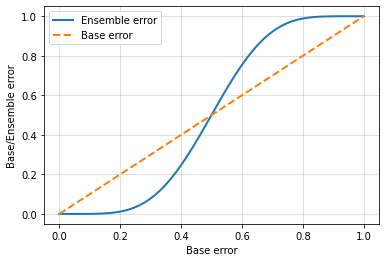

In [14]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

에러율이 0.5보다 낮으면 앙상블의 에러 확률은 개별 분류기보다 항상 좋다.

##7.2 다수결 투표를 사용한 분류 앙상블

###7.2.1 간단한 다수결 투표 분류기 구현

In [0]:
import numpy as np

In [16]:
np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

1

In [18]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
print(np.argmax(p))

[0.58 0.42]
0


In [0]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
      앙상블에 사용할 분류기

    vote : str, {'classlabel', 'probability'}
      기본값: 'classlabel'
      'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다.
      'probability'이면 확률 합이 가장 큰 인덱스로 
      클래스 레이블을 예측합니다(보정된 분류기에 추천합니다).

    weights : 배열 타입, 크기 = [n_classifiers]
      선택사항, 기본값: None
      `int` 또는 `float` 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다.
      `weights=None`이면 동일하게 취급합니다.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다.

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬

        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터

        반환값
        -------
        self : 객체

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다."
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기 개수와 가중치 개수는 동일해야 합니다.'
                             '; %d개의 가중치와, %d개의 분류기가 입력되었습니다.'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때 
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다.

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬

        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            #  clf.predict 메서드를 사용해 결과를 모읍니다.
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다.

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수이고 n_features는 특성의 개수인
            샘플 데이터 행렬

        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해서 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

###7.2.2 다수결 투표 방식을 사용하여 예측 만들기

In [0]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [105]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(solver='liblinear',
                          penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [106]:
# 다수결 투표 (클래스 레이블 카운트)

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


###7.2.3 앙상블 분류기의 평가와 튜닝

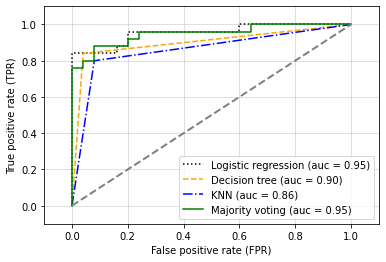

In [110]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
  # 양성 클래스의 레이블이 1이라고 가정
  y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

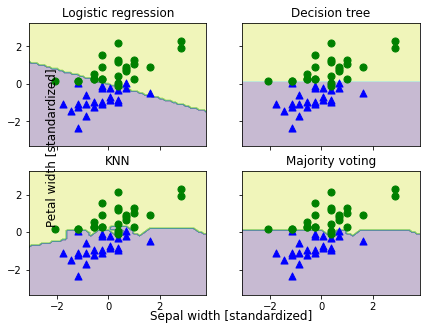

In [111]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
  clf.fit(X_train_std, y_train)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^',
                                s=50)
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                X_train_std[y_train==1, 1],
                                c='green',
                                marker='o',
                                s=50)
  axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5,
         s='Petal width [standardized]',
         ha='center', va='center', 
         fontsize=12, rotation=90)
plt.show()

In [114]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth' : [1, 2],
          'pipeline-1__clf__C' : [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: 0.98


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


##7.3 배깅: 부트스트랩 샘플링을 통한 분류 앙상블

배깅(bootstrap aggregating) : 앙상블에 있는 개별 분류기를 동일한 훈련 세트로 학습하는 것이 아니라 원본 훈련 세트에서 부트스트랩(bootstrap) 샘플(중복을 허용한 랜덤 샘플)을 뽑아서 사용한다.

###7.3.1 배깅 알고리즘의 작동 방식

예를 들면, 일곱 개의 훈련 샘플이 있다고 가정하자.

배깅 단계마다 중복을 허용하여 랜덤하게 샘플링된다.

각각의 부트스트랩 샘플을 사용하여 분류기를 학습한다.

일반적으로 가지치기하지 않는 결정 트리를 분류기로 사용한다.

중복을 허용한 샘플링을 하기 때문에 각 부분 집합에는 일부가 중복되어 있고 원본 샘플 중 일부는 포함되어 있지 않을 수도 있다.

개별 분류기가 부트스트랩 샘플에 학습되고 나면 다수결 투표를 사용하여 예측을 모은다.



###7.3.2 배깅으로 Wine 데이터셋의 샘플 분류

In [0]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# 클래스 1 제외하기
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [119]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


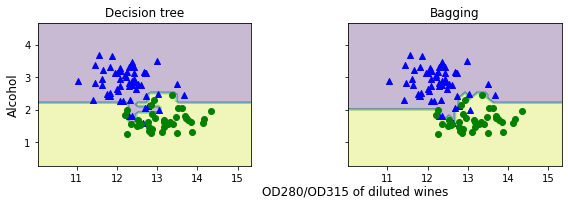

In [120]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

고차원 데이터셋을 사용하는 더 복잡한 분류 문제라면 단일 경정 트리가 쉽게 과대적합될 수 있다.

이런 경우에 배깅 알고리즘의 강력함이 제대로 발휘된다.

배깅 알고리즘은 모델의 분산을 감소하는 효과적인 방법이지만 모델의 편향을 낮추는 데는 효과적이지 않다.

이것이 배깅을 수행할 때 편향이 낮은 모델, 예를 들어 가지치기하지 않은 결정 트리를 분류기로 사용하여 앙상블을 만드는 이유이다.

##7.4 약한 학습기를 이용한 에이다부스트

부스팅(boosting) : 앙상블을 약한 학습기(weak learner)인 매우 간단한 분류기로 구성한다. 이 분류기는 랜덤 추측보다 조금 성능이 좋다. 전형적인 예로 깊이가 1인 결정 트리가 있다. 부스팅의 핵심 아이디어는 분류하기 어려운 훈련 샘플에 초점을 맞추는 것이다. 즉, 잘못 분류된 훈련 샘플을 그다음 약한 학습기가 학습하여 앙상블 성능을 향상시킨다.

에이다부스트(AdaBoost, Adaptive Boosting) : 가장 유명한 부스팅 구현

###7.4.1 부스팅 작동 원리

배깅과 달리 부스팅의 초창기 방법은 중복을 허용하지 않고 훈련 세트에서 랜덤 샘플을 추출하여 부분 집합을 구성한다.

1. 훈련 세트에서 중복을 허용하지 않고 랜덤한 부분 집합을 뽑아 약한 학습기를 훈련한다.

2. 훈련 세트에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분 집합을 뽑고 이전에 잘못 분류된 샘플의 50%를 더해서 약한 학습기를 훈련한다.

3. 훈련 세트에서 1.과 2.에서 잘못 분류한 훈련 샘플을 찾아 세 번째 약한 학습기로 훈련한다.

4. 약한 학습기 세 개를 다수결 투표로 연결한다.

###7.4.2 사이킷런에서 에이다부스트 사용

In [0]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [122]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875
에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.917


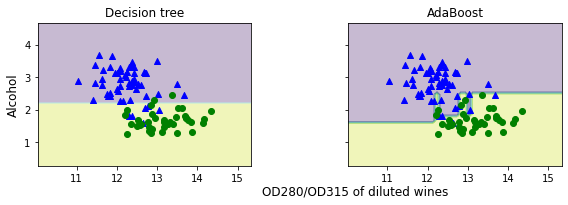

In [123]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [125]:
# 부스팅 알고리즘 중 인기 있는 다른 알고리즘은 그래디언트 부스팅(Gradient Boosting)이다.
# 에이다부스트와는 달리 이전의 약한 학습기가 만든 잔차 오차(residual error)에 대해 학습하는 새로운 학습기를 추가한다.
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)

gbrt.fit(X_train, y_train)
gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)

print('앙상블에 사용한 트리 개수 %d' % gbrt.n_estimators_)
print('그래디언트 부스팅 train/test 정확도 %.3f/%.3f'
      % (gbrt_train_score, gbrt_test_score))

앙상블에 사용한 트리 개수 20
그래디언트 부스팅 train/test 정확도 1.000/0.917


##7.5 요약

앙상블 방법은 개별 분류기의 약점을 보완하기 위해 다양한 모델을 결합한다.

배깅은 훈련 세트에서 랜덤한 부트스트랩 샘플을 추출하고 다수결 투표를 통해 훈련된 개별 분류기를 결합함으로써 모델의 분산을 감소시킨다.

에이다부스트는 오차로부터 점진적으로 학습하는 약한 학습기를 기반으로 하는 알고리즘이다.